# Heating an atom by photon scattering
a classical simulation to estimate the rate atoms are heated out of a dipole trap as they are periodically
excited with a pi pulse 

In [1]:
from numpy import *
import matplotlib.pyplot as plt

# local imports
from simfuncs import *
from rbconsts import *
from physconsts import *
from amophys import dipole_trap

## pseudocode

In [ ]:
# initialize a spatial distribution of atoms

# initialize a momentum distribution of atoms

# arrays to record the positions and momenta of the atoms. initialize with above distributions

# array to record excitations before ejection

# for each atom in the ensemble:

    # while the atom is not ejected, or while number of trials is less than some generous upper bound:

        # excite the atom from the +x direction with a pi pulse, i.e. add hbar*k to the x momentum

        # the atom decays with probability 1 as t->inf. add hbar*k along a random direction

        # does the atom's energy exceeds the trap depth?

            # if yes, exit the excitation loop for this atom

## simulation - unidirectional excitation

zr=3.88 [um], wx=1.00 [um]


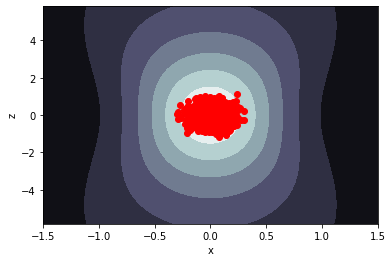

In [279]:
# parameter setup: dipole trap and atom temp
w0 = 1e-6 # 1/e^2 waist of trap [m]
T_trap = 5e-4 # energy depth [K]
T_atom = 1e-5
lmbda_trap = .81e-6 # [m]
lmbda_atom = .78e-6 # [m]
k_atom = 2*pi/lmbda_atom
n_atoms = 50000
t_pi = .2e-6 # [s] from C.B. Young et al
t_det = 3e-6 # [s] from C.B. Young et al
max_trials = 100 # avoid infinite loops

# my dipole trap object for getting atom dists
trap = dipole_trap(lmbda_trap,w0,T_trap,T_atom)

# initialize an ensemble of positions and speeds
x_dist,y_dist,z_dist = trap.xdist(n_atoms)
vx_dist,vy_dist,vz_dist = trap.vdist(n_atoms)

# check the distribution. not plotting the exact sampling
# we generated above, but from same distribution function.
trap.distplot(1000)

In [280]:
"""
some assumptions:
- atomic decay time << dt_trial = t_pi + t_det
- momentum kick is delivered in full, all at once after the
pulse has been on for t_pi. Quantum mechanically, this probably 
not true, but will be assumed inconsequential.
- the trap is NOT turned back on after each excitation and
detection cycle, but we will still decide whether the atom
is lost based on whether it would be recaptured, if we did
in fact turn the trap back on after each trial.
""";

In [281]:
# whether to record every position and velocity, or only the ones upon leaving the trap
all_trials = False 

# arrays to record the positions and momenta of the atoms. initialize with above distributions
positions = [] 
velocities = []

# array to record excitations before ejection
excitations = []

if all_trials:
    record_len = max_trials
else:
    record_len = 1

# for each atom in the ensemble:
for atom_i,x,y,z,vx,vy,vz in zip(range(n_atoms),x_dist,y_dist,z_dist,vx_dist,vy_dist,vz_dist):

    # condition the experiment on atoms that are initially trapped
    KE = .5*mRb*(vx**2+vy**2+vz**2)
    PE = trap.U(x,y,z) # the dipole trap potential energy
    if KE + PE < 0:
            
        # arrays for records
        pos_arr = empty((3,record_len))
        vel_arr = empty((3,record_len))
    
        lost = False
        trial = 0
        t = t_pi # [s]
        
        while not lost and trial < max_trials:
                                  
            # excite the atom from the +x direction with a pi pulse, i.e. add hbar*k to the x momentum
            vx += hbar*k_atom/mRb
            x += vx*t_pi
            y += vy*t_pi
            z += vz*t_pi #- g*t_pi*(2*t - t_pi)
                 
            # the atom decays with probability 1 as t->inf. 
            # add hbar*k along a random direction
            ex = 2*rand()-1
            ey = 2*rand()-1
            ez = 2*rand()-1
            A = sqrt(ex**2+ey**2+ez**2)
            vdecay = hbar*k_atom/mRb
            vx += ex*vdecay/A
            vy += ey*vdecay/A
            vz += ez*vdecay/A
            
            # update position after photon detection window
            x += vx*t_det
            y += vy*t_det
            z += vz*t_det #- g*t_det*(2*t - t_det)

            if all_trials:
                # update the position and momentum record
                pos_arr[:,trial] = array([x,y,z])
                vel_arr[:,trial] = array([vx,vy,vz])

            trial += 1
            t += t_pi + t_det
                 
            # update the atom's energy
            KE = .5*mRb*(vx**2+vy**2+vz**2)
            PE = trap.U(x,y,z) # the dipole trap potential energy
                 
            # if the atom's energy exceeds the trap depth, exit
            if KE + PE > 0:
                
                if not all_trials:
                    # update the position and momentum record
                    pos_arr[:,0] = array([x,y,z])
                    vel_arr[:,0] = array([vx,vy,vz])
                
                positions.append(pos_arr[:,:trial])
                velocities.append(vel_arr[:,:trial])
                excitations.append(trial)
                lost = True
                
# make array of all x positions, y, etc and velocity components
trapped = len(positions)
xx = concatenate([positions[i][0] for i in range(trapped)])
yy = concatenate([positions[i][1] for i in range(trapped)])
zz = concatenate([positions[i][2] for i in range(trapped)])
vxx = concatenate([velocities[i][0] for i in range(trapped)])
vyy = concatenate([velocities[i][1] for i in range(trapped)])
vzz = concatenate([velocities[i][2] for i in range(trapped)])

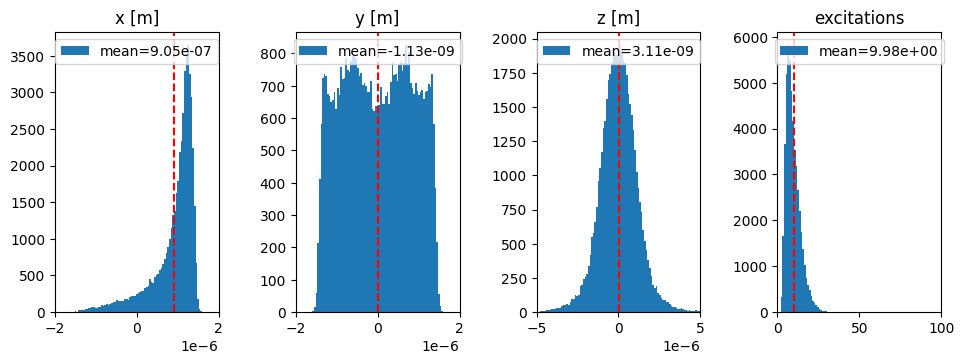

In [282]:
# plot histograms of atom final coordinates and # of cycles before atom exits the trap
binz = 100
binlist = [linspace(-2e-6,2e-6,binz),linspace(-2e-6,2e-6,binz),linspace(-5e-6,5e-6,binz),linspace(0,max_trials,binz)]
labels=['x [m]','y [m]','z [m]','excitations']
fig,axes = plt.subplots(nrows=1,ncols=4,dpi=100, figsize=(10,4))
for ax,uu,bb,l in zip(axes,[xx,yy,zz,excitations],binlist,labels):
    uubar = mean(uu)
    ax.hist(uu,bins=bb,label=f'mean={uubar:.2e}')
    ax.set_xlim((bb[0],bb[-1]))
    ax.axvline(uubar,color='r',ls='--')
    ax.set_title(l)
    ax.legend(loc='upper center')
fig.tight_layout(pad=2)
plt.show()

## simulation - bidirectional excitation

zr=3.88 [um], wx=1.00 [um]


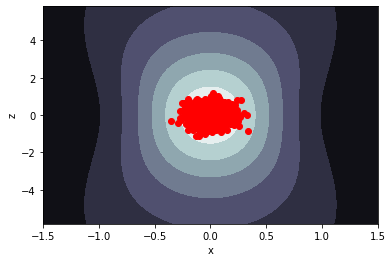

In [283]:
# parameter setup: dipole trap and atom temp
w0 = 1e-6 # 1/e^2 waist of trap [m]
T_trap = 5e-4 # energy depth [K]
T_atom = 1e-5
lmbda_trap = .81e-6 # [m]
lmbda_atom = .78e-6 # [m]
k_atom = 2*pi/lmbda_atom
n_atoms = 50000
t_pi = .2e-6 # [s] from C.B. Young et al
t_det = 3e-6 # [s] from C.B. Young et al
max_trials = 100 # avoid infinite loops

# my dipole trap object for getting atom dists
trap = dipole_trap(lmbda_trap,w0,T_trap,T_atom)

# initialize an ensemble of positions and speeds
x_dist,y_dist,z_dist = trap.xdist(n_atoms)
vx_dist,vy_dist,vz_dist = trap.vdist(n_atoms)

# check the distribution. not plotting the exact sampling
# we generated above, but from same distribution function.
trap.distplot(1000)

In [284]:
"""
some assumptions:
- atomic decay time << dt_trial = t_pi + t_det
- momentum kick is delivered in full, all at once after the
pulse has been on for t_pi. Quantum mechanically, this probably 
not true, but will be assumed inconsequential.
- the trap is NOT turned back on after each excitation and
detection cycle, but we will still decide whether the atom
is lost based on whether it would be recaptured, if we did
in fact turn the trap back on after each trial.
""";

In [285]:
# whether to record every position and velocity, or only the ones upon leaving the trap
all_trials = False 

# arrays to record the positions and momenta of the atoms. initialize with above distributions
positions = [] 
velocities = []

# array to record excitations before ejection
excitations = []

if all_trials:
    record_len = max_trials
else:
    record_len = 1

# for each atom in the ensemble:
for atom_i,x,y,z,vx,vy,vz in zip(range(n_atoms),x_dist,y_dist,z_dist,vx_dist,vy_dist,vz_dist):

    # condition the experiment on atoms that are initially trapped
    KE = .5*mRb*(vx**2+vy**2+vz**2)
    PE = trap.U(x,y,z) # the dipole trap potential energy
    if KE + PE < 0:
            
        # arrays for records
        pos_arr = empty((3,record_len))
        vel_arr = empty((3,record_len))
    
        lost = False
        trial = 0
        t = t_pi # [s]
        
        while not lost and trial < max_trials:
                                  
            # excite the atom from the +/-x direction with a pi pulse, i.e. add hbar*k to the x momentum
            # +/- direction alternates every other trial
            vx += (-1)**trial*hbar*k_atom/mRb
            x += vx*t_pi
            y += vy*t_pi
            z += vz*t_pi #- g*t_pi*(2*t - t_pi)
                 
            # the atom decays with probability 1 as t->inf. 
            # add hbar*k along a random direction
            ex = 2*rand()-1
            ey = 2*rand()-1
            ez = 2*rand()-1
            A = sqrt(ex**2+ey**2+ez**2)
            vdecay = hbar*k_atom/mRb
            vx += ex*vdecay/A
            vy += ey*vdecay/A
            vz += ez*vdecay/A
            
            # update position after photon detection window
            x += vx*t_det
            y += vy*t_det
            z += vz*t_det #- g*t_det*(2*t - t_det)

            if all_trials:
                # update the position and momentum record
                pos_arr[:,trial] = array([x,y,z])
                vel_arr[:,trial] = array([vx,vy,vz])

            trial += 1
            t += t_pi + t_det
                 
            # update the atom's energy
            KE = .5*mRb*(vx**2+vy**2+vz**2)
            PE = trap.U(x,y,z) # the dipole trap potential energy
                 
            # if the atom's energy exceeds the trap depth, exit
            if KE + PE > 0:
                
                if not all_trials:
                    # update the position and momentum record
                    pos_arr[:,0] = array([x,y,z])
                    vel_arr[:,0] = array([vx,vy,vz])
                
                positions.append(pos_arr[:,:trial])
                velocities.append(vel_arr[:,:trial])
                excitations.append(trial)
                lost = True
                
# make array of all x positions, y, etc and velocity components
trapped = len(positions)
xx = concatenate([positions[i][0] for i in range(trapped)])
yy = concatenate([positions[i][1] for i in range(trapped)])
zz = concatenate([positions[i][2] for i in range(trapped)])
vxx = concatenate([velocities[i][0] for i in range(trapped)])
vyy = concatenate([velocities[i][1] for i in range(trapped)])
vzz = concatenate([velocities[i][2] for i in range(trapped)])

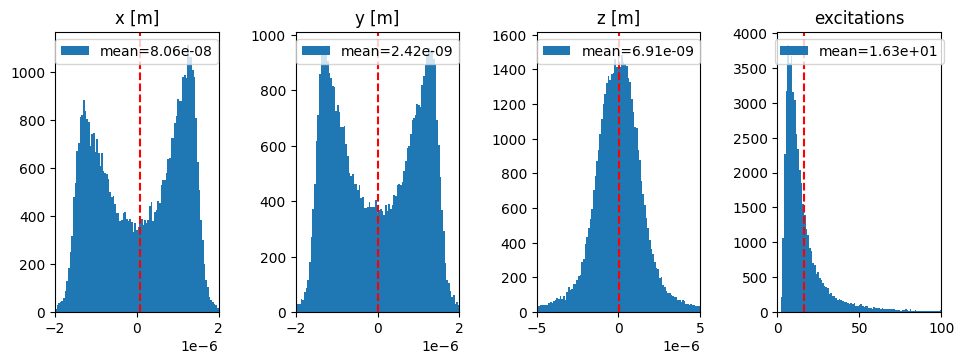

In [286]:
# plot histograms of atom final coordinates and # of cycles before atom exits the trap
binz = 100
binlist = [linspace(-2e-6,2e-6,binz),linspace(-2e-6,2e-6,binz),linspace(-5e-6,5e-6,binz),linspace(0,max_trials,binz)]
labels=['x [m]','y [m]','z [m]','excitations']
fig,axes = plt.subplots(nrows=1,ncols=4,dpi=100, figsize=(10,4))
for ax,uu,bb,l in zip(axes,[xx,yy,zz,excitations],binlist,labels):
    uubar = mean(uu)
    ax.hist(uu,bins=bb,label=f'mean={uubar:.2e}')
    ax.set_xlim((bb[0],bb[-1]))
    ax.axvline(uubar,color='r',ls='--')
    ax.set_title(l)
    ax.legend(loc='upper center')
fig.tight_layout(pad=2)
plt.show()

In [275]:
len(xx)

49927

In [263]:
mean(xx)

4.14132635795858e-07

In [261]:
ngh = mean(yy)
ngh

2.831795803010973e-09

In [262]:
ngh/(10**(int(log10(ngh)+0.5)-1))

2.831795803010973

In [208]:
ax.axvline?

In [ ]:
lbs[-]

In [201]:
log10(1e-6)

-6.0

In [194]:
len(xx)

4

(array([ 2.,  8.,  4., 16.,  0.,  0., 10.,  2.,  7.,  4.]),
 array([-0.09950837, -0.07669938, -0.05389039, -0.0310814 , -0.00827242,
         0.01453657,  0.03734556,  0.06015455,  0.08296353,  0.10577252,
         0.12858151]),
 <BarContainer object of 10 artists>)

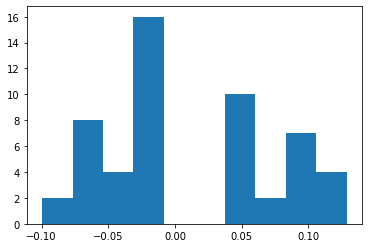

In [155]:
# plt.hist(xx)
plt.hist(vzz)

In [120]:
positions[8][0]

array([-4.03650338e-07, -7.06649623e-07, -9.98149961e-07])

(-1.5e-06, 1.5e-06)

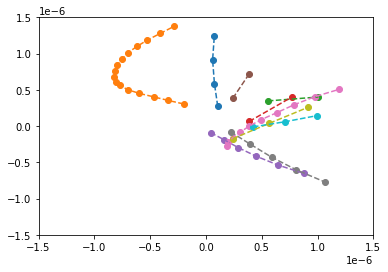

In [142]:
for ai in range(n_atoms):
    plt.scatter(positions[ai][0],positions[ai][1])
    plt.plot(positions[ai][0],positions[ai][1],'--')
plt.xlim((-1.5e-6,1.5e-6))
plt.ylim((-1.5e-6,1.5e-6))

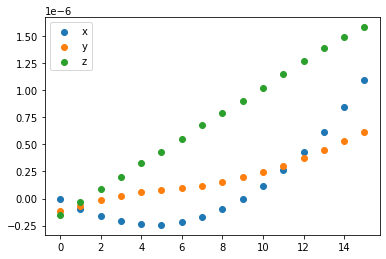

In [125]:
ai = 2# int(100*rand())
trials = len(positions[ai][0])
plt.scatter(range(trials),positions[ai][0],label='x')
plt.scatter(range(trials),positions[ai][1],label='y')
plt.scatter(range(trials),positions[ai][2],label='z')
# plt.xlim((0,100))
# plt.ylim((-1e-5,1e-5))
plt.legend()

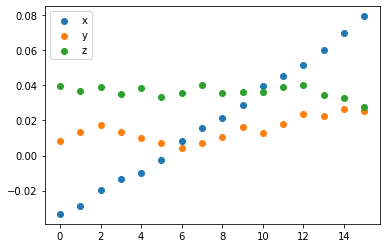

In [126]:
ai = 2# int(100*rand())
trials = len(positions[ai][0])
plt.scatter(range(trials),velocities[ai][0],label='x')
plt.scatter(range(trials),velocities[ai][1],label='y')
plt.scatter(range(trials),velocities[ai][2],label='z')
# plt.xlim((0,100))
# plt.ylim((-1e-5,1e-5))
plt.legend()

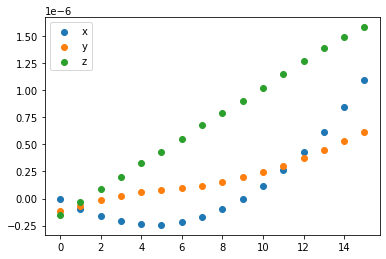

In [125]:
ai = 2# int(100*rand())
trials = len(positions[ai][0])

energy = positions[ai][0]**2+positions[ai][1]**2+positions[ai][2]**2
plt.scatter(range(trials),positions[ai][0],label='x')
plt.scatter(range(trials),positions[ai][1],label='y')
plt.scatter(range(trials),positions[ai][2],label='z')
# plt.xlim((0,100))
# plt.ylim((-1e-5,1e-5))
plt.legend()

In [88]:
positions[0,i,:10]

array([2.34686739e-07, 5.83785300e-07, 9.38983139e-07, 1.30550306e-06,
       1.69728764e-06, 2.11469236e-06, 2.53998126e-06, 2.99195665e-06,
       3.47592520e-06, 3.99374139e-06])

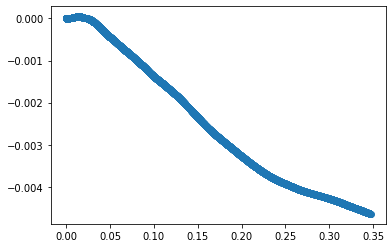

In [89]:
imax = 6000
plt.scatter(positions[0,i,:imax],positions[1,i,:imax])
# plt.plot(positions[0,i,:10],positions[1,i,:10],linestyle='--')